<a href="https://colab.research.google.com/github/kikiru328/Bone_Detection/blob/main/%EC%8A%B9%ED%98%9C/img_processing_tmdhey.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# img_path = "/content/drive/MyDrive/cakd_colab/2차플젝/데이터 원본-20211021T022528Z-001/데이터 원본/first"

In [84]:
def show(img):
    plt.figure(figsize=(15, 10))
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img, cmap = "gray")
    plt.show()

In [198]:
from google.colab import files
uploaded = files.upload()

Saving 1_F_손목.jpg to 1_F_손목 (2).jpg


In [117]:
# import 

import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import glob
import math

In [170]:
# image 가져오기 
img = cv2.imread('1_F_손목.jpg',cv2.IMREAD_COLOR)
img_ = img.copy()


## 이미지 회전

cv2.getRotationMatrix2D(center, angle, scale) -> retval

• center: 회전 중심 좌표. (x, y) 튜플.

• angle: (반시계 방향) 회전 각도(degree). 음수는 시계 방향.

• scale: 추가적인 확대 비율

• retval: 2x3 어파인 변환 행렬. 실수형.


회전 중심 좌표는 영상의 가로, 세로 1/2 값을 넣어주면 영상의 중앙 좌표로 설정할 수 있습니다.

 cv.2getRotationMatrix2D 함수는 결과 값을 2x3 어파인 변환 행렬을 반환합니다.

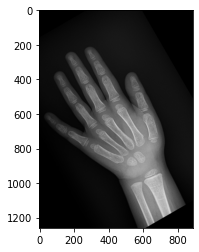

In [ ]:
def rotate_image(image, angle):
    image_center = tuple(np.array(image.shape[1::-1]) / 2)
    rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
    result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR,borderMode=cv2.BORDER_CONSTANT,borderValue=(0,0,0))
    return result

a= rotate_image(img,30) # 이미지, 각도
plt.imshow(a)
plt.show()

### 이미지 회전 코드 뜯어보기

In [ ]:
# img 크기 (세로,가로,층)
print(img.shape)
print(tuple(np.array(img.shape)))

(1260, 888, 3)
(1260, 888, 3)


In [ ]:
image_center = tuple(np.array(img.shape[1::-1]) / 2)
image_center

# 1부터 끝까지 -1칸 간격으로 ( == 역순으로) /2
# 원래 (세로,가로,층)인데 (가로,세로)로 만들고싶어서 [1::-1] 
# 그리고 거기서 중간지점 구하고싶어서 /2
# (가로,세로,층)

(444.0, 630.0)

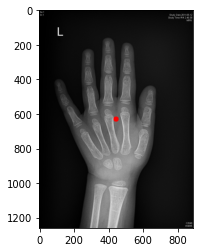

In [ ]:
# img에 중심 좌표 찍기 (가로,세로)형식으로 넣어줘야함
red_color=(255,0,0)
center= cv2.line(img,(444,630),(444,630),red_color,30)

plt.imshow(center)
plt.show()

In [ ]:
# 이동 변환 표현하는 <변환 행렬>
# 영상의 특정 지점을 기준(image_center)으로 회전(angle만큼), scale만큼 확대시켜서
rot_mat = cv2.getRotationMatrix2D(image_center, 10, 1.0) # 이미지 중심지점을 기준으로 
rot_mat


array([[   0.98480775,    0.17364818, -102.65299427],
       [  -0.17364818,    0.98480775,   86.67090649]])

cv2.warpAffine(src, M, dsize, dst=None, flags=None, 
borderMode=None, borderValue=None) -> dst

• src: 입력 영상

• M: 2x3 어파인 변환 행렬. 실수형.

• dsize: 결과 영상 크기. (w, h) 튜플. (0, 0)이면 src와 같은 크기로 설정.

• dst: 출력 영상

• flags: 보간법. 기본값은 cv2.INTER_LINEAR. ( a와 b 사이의 x 값, 즉 f(x)를 추정하는 방법)

• borderMode: 가장자리 픽셀 확장 방식. 기본값은 cv2.BORDER_CONSTANT.

• borderValue: cv2.BORDER_CONSTANT일 때 사용할 상수 값. 기본값은 0(검정색).

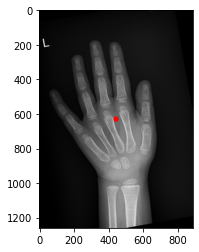

In [ ]:
# 이동 변환을 표현하는 어파인 변환 행렬을 만든 후 
# cv2.warpAffine 함수로 넘겨주면 이동 변환 완성!

# # 0,0 의미는 입력영상 크기와 동일한 출력 영상 생성
result = cv2.warpAffine(img,# 이미지 
                        rot_mat, # 변환행렬
                        img.shape[1::-1], # 결과 영상 크기 (888,1260)
                        flags=cv2.INTER_LINEAR, # 선형 보간법(기본)
                        borderMode=cv2.BORDER_CONSTANT, # 기본값으로
                        borderValue=(0,0,0)) 

## 참고 (정확도 높일 때 바꿔볼 수 있을지도?)
# flags  --     cv2.INTER_LINEAR - 양선형 보간법(2x2 이웃 픽셀 참조) : 효율굿 속도굿 퀄리티적당 
# flags  --     cv2.INTER_CUBIC - 3차회선 보간법(4x4 이웃 픽셀 참조) : LINEAR 보다 느리지만 퀄리티 더 좋음 
plt.imshow(result)
plt.show()

## 전처리 코드

In [202]:
img= img_.copy()

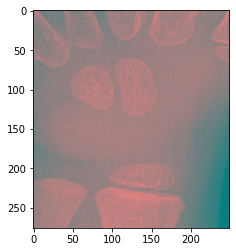

In [203]:
# opencv(bgr) 에서 matplotlib(rgb)로 변경
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# 이진화
# 마스크 생성을 위해 밝기 강조한 Lab으로 이미지 변환 
# Lab : 조명의 영향 없애기 (조명이 있으면 이미지,배경 분리가 어려움. / lab은 lightness 가장 잘 분리)
# Median Filter 과정을 거쳐 조명의 상태를 알아낸 다음 반전 시켜 역조명 채널을 만들어 냄
# 이를 원본 영상에 합성하여 Clear 한 Image 를 만들어 내기
img = cv2.cvtColor(img, cv2.COLOR_BGR2Lab)

plt.imshow(img)
plt.show()

 ***cv2.getStructuringElement(shape, ksize, anchor)***

- shape: 구조화 요소 커널 모양 (cv2.MORPH_RECT: 사각형, cv2.
- MORPH_EPLIPSE: 타원형, cv2.MORPH_CROSS: 십자형)

- ksize: 커널 크기

- anchor(optional): 구조화 요소의 기준점, cv2.MORPH_CROSS에만 
의미 있으며 기본 값은 중심점 (-1, -1)
----------------------------------------
***dst = cv2.morphologyEx(src, op, kernel, dst, anchor, iteration, borderType, borderValue)***
- src: 입력 영상
- op: 모폴로지 연산 종류 (cv2.MORPH_OPEN: 열림 연산, cv2.MORPH_COLSE: 닫힘 연산, cv2.MORPH_GRADIENT: 그레디언트 연산, cv2.MORPH_TOPHAT: 탑햇 연산, cv2.MORPH_BLACKHAT: 블랙햇 연산)
- kernel: 구조화 요소 커널
- dst(optional): 결과 영상
- anchor(optional): 커널의 기준점
- iteration(optional): 연산 반복 횟수
- borderType(optional): 외곽 영역 보정 방법
- borderValue(optional): 외곽 영역 보정 값

- 열림 = 침식+팽창
- 닫힘 = 팽창+침식
- 그래디언트 = 팽창-침식
- 탑햇 = 원본-열림
  * 원본에서 열림 연산 적용 결과를 빼면 값이 크게 튀는 밝은 영역을 강조 
- 블랙햇= 원본-닫힘

- 열림 연산은 주변보다 밝은 노이즈를 제거하는데 효과적/ 맞닿아 있는 것처럼 보이는 독립된 개체를 분리하거나 돌출된 모양을 제거하는 데 효과적

- 닫힘 연산은 주변보다 어두운 노이즈를 제거하는데 효과적/ 끊어져 보이는 개체를 연결하거나 구멍을 메우는 데 효과적

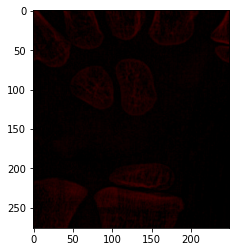

In [204]:
# 원본-열림 : 값이 크게 튀는 밝은 영역 강조
k = cv2.getStructuringElement(cv2.MORPH_CROSS, (50, 50))
img = cv2.morphologyEx(img, cv2.MORPH_TOPHAT, k)

plt.imshow(img)
plt.show()

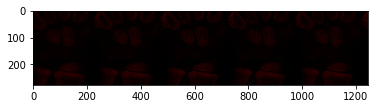

In [205]:
# 블러 필터 차이
blur1 = cv2.GaussianBlur(img, (15, 15), 0)
blur2 = cv2.GaussianBlur(img, (9, 9), 0)
blur3 = cv2.medianBlur(img, 3)
blur4 = cv2.medianBlur(img, 9)
blur5= cv2.bilateralFilter(img,-1, 10, 5)

merged = np.hstack((blur1, blur2, blur3,blur4,blur5))
 
plt.imshow(merged)
plt.show()



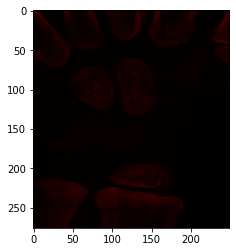

In [206]:
# 미디안 블러필터 적용
# img = cv2.medianBlur(img, 3)

img= cv2.bilateralFilter(img,-1, 10, 5)
plt.imshow(img)
plt.show()

In [207]:
# Lab에서 Grayscale로 이미지 변환 for threshold

img = cv2.cvtColor(img, cv2.COLOR_Lab2BGR)
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

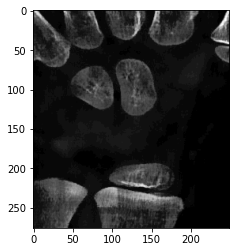

In [208]:
plt.imshow(img, cmap='gray')
plt.show()

**cv2.threshold(src, thresh, maxval, type, dst=None) -> retval, dst**

• src: 입력 영상. 다채널, 8비트 또는 32비트 실수형

• thresh: 사용자 지정 임계값

• maxval: cv2.THRESH_BINARY 또는 cv2.THRESH_BINARY_INV 방법 사용 시 최댓값. 보통 255로 지정.

• type: cv2.THRESH_ 로 시작하는 플래그. 임계값 함수 동작 지정 또는 자동 임계값 결정 방법 지정

• retval: 사용된 임계값

• dst: 출력 영상. src와 동일 크기, 동일 타입, 같은 채널 수

In [209]:
np.mean(img)

63.64670275304115

In [210]:
# 이진화 : 이미지 픽셀값을 0 or 255(1)로 바꾸는 작업 (배경과 객체 구분)
ret, mask = cv2.threshold(img, 
                          np.mean(img), # thresh= 이미지의 평균값을 임계치로
                          255,
                          cv2.THRESH_BINARY)


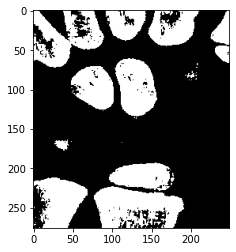

In [211]:
plt.imshow(mask, cmap='gray')
plt.show()

**dst, contours, hierarchy = cv2.findContours(src, mode, method, contours, hierarchy, offset)**
- src: 입력 영상, 검정과 흰색으로 구성된 바이너리 이미지
- mode: 컨투어 제공 방식 (cv2.RETR_EXTERNAL: 가장 바깥쪽 라인만 생성, cv2.RETR_LIST: 모든 라인을 계층 없이 생성, cv2.RET_CCOMP: 모든 라인을 2 계층으로 생성, cv2.RETR_TREE: 모든 라인의 모든 계층 정보를 트리 구조로 생성)
- method: 근사 값 방식 (cv2.CHAIN_APPROX_NONE: 근사 없이 모든 좌표 제공, cv2.CHAIN_APPROX_SIMPLE: 컨투어 꼭짓점 좌표만 제공, - cv2.CHAIN_APPROX_TC89_L1: Teh-Chin 알고리즘으로 좌표 개수 축소, cv2.CHAIN_APPROX_TC89_KC0S: Teh-Chin 알고리즘으로 좌표 개수 축소)
- contours(optional): 검출한 컨투어 좌표 (list type)
- hierarchy(optional): 컨투어 계층 정보 (Next, Prev, FirstChild, Parent, -1 [해당 없음])
- offset(optional): ROI 등으로 인해 이동한 컨투어 좌표의 오프셋


**cv2.drawContours(img, contours, contourIdx, color, thickness)**
- img: 입력 영상
- contours: 그림 그릴 컨투어 배열 (cv2.findContours() 함수의 반환 결과를 전달해주면 됨)
- contourIdx: 그림 그릴 컨투어 인덱스, -1: 모든 컨투어 표시
- color: 색상 값
- thickness: 선 두께, 0: 채우기

In [212]:
# 같은 픽셀 강도를 갖는 애들 연결해줌 (오브젝트 검출)
contours, hierarchy = cv2.findContours(mask, # 마스크에서
                                       cv2.RETR_EXTERNAL, # 바깥쪽 라인만
                                       cv2.CHAIN_APPROX_SIMPLE) # 컨투어 꼭짓점 좌표만 제공 
# 그려주기
cv2.drawContours(mask, contours,
                 -1, (255, 255, 255), -1) # -1: 모든 컨트어 표시 

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0]], dtype=uint8)

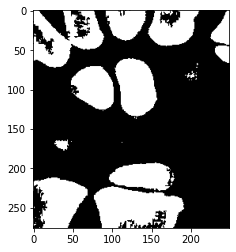

In [213]:
plt.imshow(mask, cmap='gray')
plt.show()

---------------------------------------------------------

In [214]:
#### 강 조
# 모폴로지
k = cv2.getStructuringElement(cv2.MORPH_RECT, (50, 50))
img = cv2.morphologyEx(img, cv2.MORPH_TOPHAT, k)

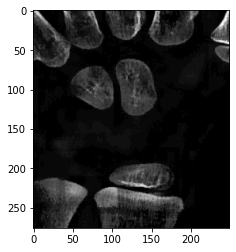

In [215]:
plt.imshow(img, cmap='gray')
plt.show()

In [216]:
# contrast
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

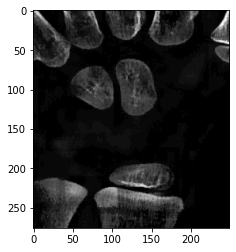

In [217]:
plt.imshow(img, cmap='gray')
plt.show()

In [218]:
# 각 img의 평균 픽셀값에 따라 low값과 high값 가중치 설정? 
if img.mean() <= 15:
    low = img.mean() * 1.5
    high = img.mean() * 1.6
elif img.mean() <= 20:
    low = img.mean() * 1.5
    high = img.mean() * 1.8
else:
    low = img.mean() * 1.5
    high = img.mean() * 2

In [219]:
# def contrast_roi(img, low, high):
#     # contrast 를 위한 zero 행렬
#     h, w = img.shape  # (1260,888)
#     img_ = np.zeros(img.shape, dtype=np.uint8) # (1260,888) zero 행렬

#     for y in range(h):  # 1260행 중에서(0~1259) 
#         for x in range(w): # 888열 중에서
#             temp = int((255 / (high - low)) * (img[y][x] - low))
#             # temp가 255보다 크면 255(1)로 
#             if temp > 255:
#                 img_[y][x] = 255

#             # temp가 0보다 작으면 0으로 
#             elif temp < 0:
#                 img_[y][x] = 0
            
#             # 0~255 사이에 있으면 그 값 그대로 
#             else:
#                 img_[y][x] = temp

#     return img_

In [220]:
def contrast(img, mask):
    # # Morphlogy - Tophat
    # ksize = int(img.mean() * 0.5)
    # k = cv2.getStructuringElement(cv2.MORPH_RECT, (ksize, ksize))
    # img = cv2.morphologyEx(img, cv2.MORPH_TOPHAT, k)

    # contrast
    low = int(img.mean())*1.3
    high = low + 100
    height, width = img.shape
    
    img = img.astype("float")
    img_ = (255 / (high - low)) * (img-low)
    img_ = ((img_>0)*img_)
    img_ = ((img_-255)>0)*255+img_*(img_<255)
    img_ = img_.astype("uint8")  
    # 마스크 씌우기
    img = cv2.bitwise_and(img_, mask)

    return img

In [221]:
img= contrast(img,mask)

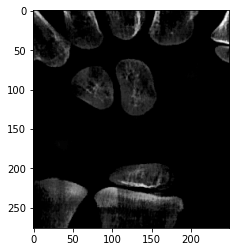

In [222]:
plt.imshow(img, cmap='gray')
plt.show()

In [223]:
# 뼈강조하고 마스크랑 비트 연산
# 모폴로지
k2 = cv2.getStructuringElement(cv2.MORPH_RECT, (500, 500))
img = cv2.morphologyEx(img, cv2.MORPH_TOPHAT, k2)


In [224]:
# 컨투어
contours, hierarchy = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cv2.drawContours(img, contours, -1, (255, 255, 255), -1)

# 마스크랑 비트 연산 - 이미지랑 마스크 둘 다에서 흰색인 부분만 출력
img = cv2.bitwise_and(img, mask) 

# 크기 표준화
img = cv2.resize(img, (256, 256), interpolation=cv2.INTER_AREA)
img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)


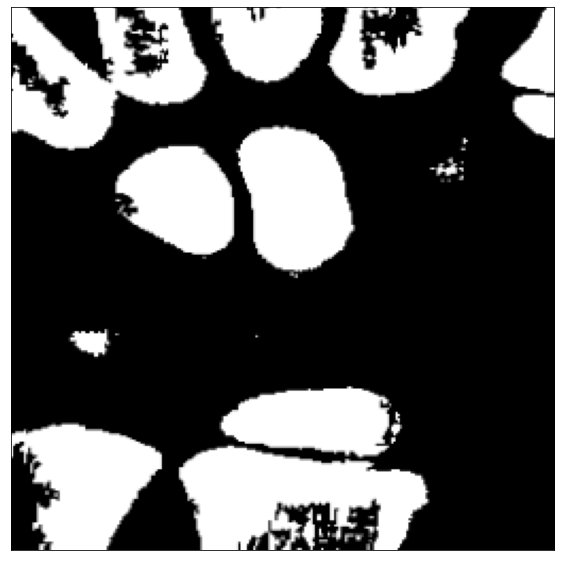

In [225]:
show(img)